## Logistic Regression

I first estimate a multinomial logistic regression model to classify the state of a mortgage in period $t$ using information available at time $t-1$. Logistic regression can be thought of as a neural network with no hidden layers, and serves as a useful benchline with which to compare the performance of more sophisticated neural networks.  

In any month,  the state of a mortgage must be current, delinquent, in foreclosure, or paid-off.  I model the probability that mortgage $i$ is in state $k$ as $$Pr\left(y_{it}=k|X_{i,t-1}\right) = \frac{e^{X_{i, t-1}\beta_k}}{\sum_{K=0}^{K-1}e^{X_{i, t-1}\beta_K}}$$ for $k=\{current, delinquent, foreclosure, paid-off\}$. The predicted state for each mortgage is then $\hat{y}_{it}=argmax_{k}$ $\hat{p}_{ik}$ where $\hat{p}_{ik}$ is the probability that mortgage $i$ is in state $k$. The vector $\hat{\beta}_k$ must be estimated for each state so that predicted probabilities can be obtained. I first import my data and create a validation and training set before estimating each of the $\hat{\beta}_k$s with the sklearn package.

In [15]:
import os
os.getcwd()
os.chdir('C:\\Users\\dzink\\Documents\\fannie')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import math
#Import training data. The data was cleaned in R and saved as a CSV while working on another project. 
data=pd.read_csv('training_data.csv')

features=['l_delinquent', 'loan_age', 'months_left', 'estimated_ltv', 'fico', 'units_1', 'units_2', 'units_3', 'units_4', 
		'occupancy_I', 'occupancy_P', 'occupancy_S' , 'o_cltv', 'o_dti', 'o_upb' ,'o_ltv', 
		'property_type_CP', 'property_type_MH', 'property_type_CO', 'property_type_PU', 'property_type_SF', 
		'fist_home_9', 'fist_home_Y', 'fist_home_N', 'o_term', 'borrowers', 'nontradable_xshare',
		 'other_xshare', 'tradable_xshare', 'tot_emp_xshare', 'white_xshare', 'LaborForce_xshare', 'Employed_xshare', 
		'Unemployed_xshare', 'spread', 'spread_ltv', 'spread_fico', 'spread_unemp']

#shuffle dataframe so that the validation and training datasets are random
data=data.sample(frac=1, random_state=1)
y=pd.get_dummies(pd.DataFrame(data['delinquent']).astype('category'))
y.columns=['current', 'delinquent', 'foreclosed', 'prepaid']

# Convert the data to mean zero and unit standard deviation
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
data_scaler=scaler.fit(data[features])
data_scaled=pd.DataFrame(data_scaler.transform(data[features]), columns=data[features].columns)
data_scaled['sequence']=data['sequence']

The features are defined aboce. Categorical features are all one-hot encoded and include month, units, occupancy, property type, borrowers, and l_delinquency (the state of the mortgage in period  𝑡−1 ). The remaining features are continuous. These may vary at either the loan level, geographical level, or national level. Among the loan level features, these may be either time varying or fixed within each individual over the course of the sampling period. For example, 'o_ltv' is the loan-to-value ratio at origination and varies only between individuals. Conversely, 'l_estimated_ltv' is the estimated loan-to-value ratio of the loan as of period  𝑡−1 , which is time-varying. Importantly, the presence of time varying features means that only one-month ahead predictions can be made. Summaries of the features matrix and output vector are printed below.

In [190]:
data_scaled[features].describe()

,l_delinquent,loan_age,months_left,estimated_ltv,fico,units_1,units_2,units_3,units_4,occupancy_I,...,tradable_xshare,tot_emp_xshare,white_xshare,LaborForce_xshare,Employed_xshare,Unemployed_xshare,spread,spread_ltv,spread_fico,spread_unemp
count,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,...,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06
mean,-1.385709e-14,6.071913e-16,-3.119414e-16,3.756472e-15,8.828725e-16,-1.168960e-14,-1.718810e-14,-1.250499e-14,1.467029e-14,-5.152808e-15,...,-1.532299e-15,-8.526550e-16,-1.778782e-15,7.285070e-15,-5.692868e-15,-9.760309e-16,-2.722898e-16,-3.372668e-16,1.391122e-16,1.731336e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.826500e-01,-1.324601e+00,-7.483346e+00,-3.512710e+00,-5.653302e+00,-6.611839e+00,-1.354083e-01,-4.272627e-02,-5.041947e-02,-2.668625e-01,...,-1.291623e+00,-2.372234e+00,-5.269511e+00,-4.952113e+00,-4.529680e+00,-1.787457e+00,-2.460347e+00,-3.160036e+00,-2.565471e+00,-3.078625e+00
25%,-1.826500e-01,-8.199049e-01,-6.137461e-01,-5.395782e-01,-7.170121e-01,1.512439e-01,-1.354083e-01,-4.272627e-02,-5.041947e-02,-2.668625e-01,...,-7.443683e-01,-7.345819e-01,-4.491718e-01,-5.665151e-01,-5.785580e-01,-7.079228e-01,-7.889598e-01,-7.387046e-01,-7.809508e-01,-7.193905e-01
50%,-1.826500e-01,-1.890341e-01,1.602933e-01,8.322330e-02,1.665263e-01,1.512439e-01,-1.354083e-01,-4.272627e-02,-5.041947e-02,-2.668625e-01,...,-2.445164e-01,-1.276063e-01,1.814924e-01,1.891580e-02,1.630456e-02,-2.658311e-01,-2.512754e-01,-2.723958e-01,-2.471197e-01,-3.791602e-01
75%,-1.826500e-01,6.184805e-01,7.650116e-01,6.169211e-01,8.195763e-01,1.512439e-01,-1.354083e-01,-4.272627e-02,-5.041947e-02,-2.668625e-01,...,5.526084e-01,6.097267e-01,7.374441e-01,6.463802e-01,6.756381e-01,4.633725e-01,7.175710e-01,6.313151e-01,7.166373e-01,6.220300e-01
max,5.474952e+00,2.864380e+00,4.127245e+00,8.829044e+00,2.106469e+00,1.512439e-01,7.385073e+00,2.340480e+01,1.983361e+01,3.747248e+00,...,8.048821e+00,8.320831e+00,1.507352e+00,5.318197e+00,5.212446e+00,4.484992e+00,4.131360e+00,8.318794e+00,4.243316e+00,7.497968e+00


In [191]:
y.describe()

,current,delinquent,foreclosed,prepaid
count,5.345713e+06,5.345713e+06,5.345713e+06,5.345713e+06
mean,9.552585e-01,3.249482e-02,6.891504e-04,1.155749e-02
std,2.067357e-01,1.773102e-01,2.624263e-02,1.068827e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


I now construct and estimate the multinomial logistic regression model. I use class weights to account for class imbalanceness. Specifically, the weight for class  𝑘  is equal to the frequency of the 'current' class to class  𝑘 . This adjusts the loss function for class-imbalance by multiplying observations from each class by their respective weight.

In [11]:
# I will train a logistic regression model using keras with a tensorflow backend 
import tensorflow as tf
import keras as k
from keras.layers import Dense, Dropout
from keras.models import Sequential
#define class weights to account for imbalanced data
class_weight = {0: 1,
                1: 29.5434, 
                2: 1393.82, 
                3: 83.006}

model0=Sequential()
model0.add(Dense(4, input_dim=38, activation='softmax', use_bias=True))
# I will use categorical crossentropy as a loss function. I run 4 epochs and set aside 20% of the training data for validation

model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history=model0.fit(data_scaled[features], y, batch_size=30, epochs=3, validation_split=0.2, 
                   class_weight=class_weight, verbose=1)



Train on 4276570 samples, validate on 1069143 samples
Epoch 1/3
4276570/4276570 [==============================] - 160s 37us/step - loss: 1.7176 - categorical_accuracy: 0.9282 - val_loss: 1.6183 - val_categorical_accuracy: 0.9417
Epoch 2/3
4276570/4276570 [==============================] - 156s 36us/step - loss: 1.6141 - categorical_accuracy: 0.9408 - val_loss: 1.6003 - val_categorical_accuracy: 0.9408
Epoch 3/3
4276570/4276570 [==============================] - 167s 39us/step - loss: 1.6122 - categorical_accuracy: 0.9414 - val_loss: 1.5500 - val_categorical_accuracy: 0.9410


The loss has stopped improving after two epochs, suggesting that the loss function has converged.   The validation accuracy of 94% percent looks impressive, however keep in mind that the data is highly imbalanced. 95% of the mortgages are current, and so an algorithim that predicts current for every mortgage would have a high accuracy but be useless. To get a more detailed picture of the predictive power of the logistic regression model, I import new test data and compute the recall and accuracy for each class. 



In [12]:
#Get classification report for logistic regression and predict on new data...
from sklearn.metrics import classification_report
test_data=pd.read_csv('test_data.csv')
#normalize the test data using the mean and standard deviations calculated for the training data. 
test_scaled=pd.DataFrame(data_scaler.transform(test_data[features]), columns=test_data[features].columns)
test_scaled['sequence']=test_data['sequence']
#get classification report. Each example is classified as belonging to the class for which its predicted prob is highest
print(classification_report(test_data['delinquent'], model0.predict_classes(test_scaled[features]), 
                            target_names=['current', 'delinquent', 'foreclosed', 'prepaid']))


              precision    recall  f1-score   support

     current       0.99      0.95      0.97   1291111
  delinquent       0.33      0.60      0.42     41172
  foreclosed       0.06      0.70      0.10       917
     prepaid       0.63      0.99      0.77     15361

    accuracy                           0.94   1348561
   macro avg       0.50      0.81      0.57   1348561
weighted avg       0.97      0.94      0.95   1348561



The output above displays the preciesion, recall, and f1-score for each class. Intuitively, precision calculates the share of mortgages classified as a given class that actually belong to that class. The precision of 0.99 for current means that 99% of the loans classified as current are actually current. Recall is equivalent to the true positive rate. This is equal to the share of mortgages in a given class that are correctly identified as belonging to that class. For the current class, 0.95 means that 95% of current loans were correctly identified as current. The f1-score is the harmonic mean of precision and recall. This is useful in cases of class-imbalanceness because it identifies cases in which accuracy may be very high but precision or recall are low. 

There is a tradeoff between precision and recall. The precision of a model can be improved by increasing the probability threshold at which a loan is classifed as belonging to a given class. However, this will result in a lower recall. For example, if I only classify loans as current for which the predicted probability of belonging to current is greater than 99%, then almost all of the loans I classify as current will likely be correctly labeled (precision will be high). However, many of the loans with predicted probabilities below 99% are also likely to be current, but will not be classified as such. This will lowerer recall for the current class. This will also lower the precision and increase the recall for the other classes. Determining the importance of recall versus precision is subjective and depends on the context in which the model is being used.  

The performance of the model varies widely between classes. This isn't surprising given how imbalanced the classes are. The precision of 6% for the foreclosed class may seem alarmingly low. However, keep in mind that a loan randomly classified as foreclosed has only a 0.068% chance of being correct. Thus, the model still offers substantial predictive power when compared to random guessing.  

### Feature Importance

Although the goal of this exerxise is strictly prediction, it is still interesting to determine the most predictive features. The code below plots the ten most predictive features for each class (current, delinquent, foreclosed, prepaid). Importance is measured by the absolute value of the coefficient.

Many of the features do not have the expected sign. This may be due to omitted variable bias. If an omitted variable is correlated with both a feature and the outcome, its estimate will be biased. This does not compromise the predictive power of the model, however it prevents the model from being used for causal inference.


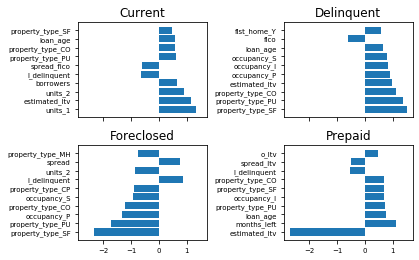

<Figure size 1500x1500 with 0 Axes>

In [9]:
weights=pd.DataFrame(model0.get_weights()[0], index=features, columns=['current', 'delinquent', 'foreclosed', 'prepaid'])
#current plot
current_weights=weights.loc[weights['current'].abs().sort_values(ascending=False)[0:10].index]
#delinquent
delinquent_weights=weights.loc[weights['delinquent'].abs().sort_values(ascending=False)[0:10].index]
#foreclosed
foreclosed_weights=weights.loc[weights['foreclosed'].abs().sort_values(ascending=False)[0:10].index]
#prepaid
prepaid_weights=weights.loc[weights['prepaid'].abs().sort_values(ascending=False)[0:10].index]


fig, axs=plt.subplots(2, 2, sharex=True)
plt.figure(figsize=(10, 10), dpi= 150, facecolor='w', edgecolor='k')
#current subplot...
axs[0,0].barh(width=current_weights['current'], y=np.arange(len(current_weights)))
axs[0,0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[0,0].set_yticklabels(current_weights.index)
axs[0,0].set_title("Current")
axs[0,0].tick_params(axis='both', which='major', labelsize=7)
#delinquent subplot....
axs[0,1].barh(width=delinquent_weights['delinquent'], y=np.arange(len(delinquent_weights)))
axs[0,1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[0,1].set_yticklabels(delinquent_weights.index)
axs[0,1].set_title("Delinquent")
axs[0,1].tick_params(axis='both', which='major', labelsize=7)
#foreclosed subplot....
axs[1,0].barh(width=foreclosed_weights['foreclosed'], y=np.arange(len(delinquent_weights)))
axs[1,0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[1,0].set_yticklabels(foreclosed_weights.index)
axs[1,0].set_title("Foreclosed")
axs[1,0].tick_params(axis='both', which='major', labelsize=7)
#Prepaid subplot....
axs[1,1].barh(width=prepaid_weights['prepaid'], y=np.arange(len(delinquent_weights)))
axs[1,1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axs[1,1].set_yticklabels(prepaid_weights.index)
axs[1,1].set_title("Prepaid")
axs[1,1].tick_params(axis='both', which='major', labelsize=7)
fig.subplots_adjust(wspace=0.6, hspace=0.3)


### Mortgage Selection

Mortgage lenders and investors are deeply concerned with minimizing default and prepayment risk on mortgages in order to ensure a steady stream of monthly cash flows. Below, I demonstrate how the logistic regression model can be used to minimize prepayment and default risk for an investor who must select a portfolios of mortgages each month. Each month, the investor is presented with 30 random samples of 500 mortgages from which 30 portfolios of 100 mortgages loans is to be selected. The goal of the investor is to select the 100 loans that are most likely to be current in the next month. For each month and each of the 30 portfolios, the investor selects these 100 mortgages by computing the probability of the loan being current in the next period using the previosuly estimated weights from the logistic regression model. The performance of the portfolio is measured as the ratio of loans in the portfolio that are actually current in the next period. For each month, the average and standard deviation of the 30 portfolios is computed. The performance of the portfolio selected using the logistic regression model is further compared with that of a naive model which randomly selects 100 mortgages that were current as of the previous month. 


In [108]:
#function that compute the performance of the logistic regression and random model
def simulator(model, reps, pool_size, portfolio_size):
    all_loans=pd.DataFrame()
    #loop through every month
    for i in sorted(test_data['month'].unique()):
        #for every month, construct N portfolios from a random sample of loans
        for j in range(1, reps+1):
            #select pool_size number of loans are random
            sample = test_data.loc[test_data['month']==i,:].sample(n=pool_size).reset_index(drop=True)
            #normalize the features 
            sample[features]=pd.DataFrame(data_scaler.transform(sample[features]), columns=sample[features].columns)
            #compute binary variable equal to 1 if mortgages is current
            sample['current']=np.where(sample['delinquent']==0, 1, 0)
            #feed the random sample into the logistic regression model to get probability estimates
            predictions=pd.DataFrame({'prediction':model.predict(sample[features])[:, 0], 'sequence': sample['sequence']})
            #construct a dataframe with one column consisting of the current status for the 100 loans 
            #most likely to be current and the other column equal to the current status for 100 randomly selected loans
            #that were current in the previous month
            loans=pd.concat([sample['current'].iloc[predictions.sort_values(by='prediction', ascending=False)[0:portfolio_size].index].reset_index(drop=True), 
                             sample['current'].loc[sample['l_delinquent']<=0].sample(n=portfolio_size).reset_index(drop=True)], axis=1)
            loans.columns=['best', 'random']
            #compute the percentage of loans that are actualy current for each of the two portfolios     
            loans=pd.DataFrame(loans.agg({'mean'}))
            loans['month']=i
            loans['group']=j
        #append this months portfolios to those from the previous months
        all_loans=all_loans.append(loans).reset_index(drop=True)
    #compute the average performance and standard deviation for the random and logistic model for each month
    all_loans=all_loans.groupby(['month']).agg({'best':['mean', 'std'], 'random':['mean', 'std']})    
    all_loans.columns = ["_".join(x) for x in all_loans.columns.ravel()]
    return all_loans


In [110]:
comparison=simulator(model0, 30, 500, 100)

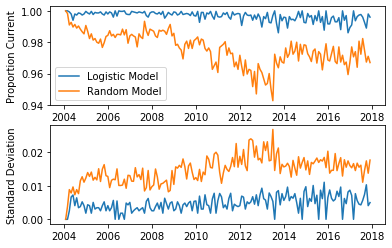

In [167]:
#make a plot summarizing the performance of the logistic and random model
fig, axis=plt.subplots(2,1)
l1=axis[0].plot(np.arange(2004.083333333, 2017.99, 1/12), comparison['best_mean'], label='Logistic Model')
l2=axis[0].plot(np.arange(2004.083333333, 2017.99, 1/12), comparison['random_mean'], label='Random Model')
l1=axis[0].set_ylabel("Proportion Current")
axis[0].legend(loc='lower left')
l3=axis[1].plot(np.arange(2004.083333333, 2017.99, 1/12), comparison['best_std'])
l4=axis[1].plot(np.arange(2004.083333333, 2017.99, 1/12), comparison['random_std'])
l4=axis[1].set_ylabel("Standard Deviation")


The figure above summarizes the performance of the logistic and random model. A few things are noteworthy. First, the average number of current loans for portfolios constructed using the logistic model are higher than that of the random model for every month in the sample. The gap between the performance of the two models widens substantially during and after the Great Recession, a period during which home foreclosures were widespread. This suggests that the model may be more valuable during times of economic instability. Furthermore, the performance of the logistic regression model is less volatile than that of the random model. This shows that the logistic model is able to consistently outperform the random model in each month. Also of note is the fact that the performance and standard deviation of the logistic model gradually deteriorate as we move further from the origination date. This is likely due to the fact that many of the borrower-level features are fixed at origination. As we move through time, these features become noisier measures of borrower quality, which hurts the performance of the model. 

## Artificial Neural Network

I now increase the complexity of the model by training a feed-forward neural network with one hidden layer. Neural networks can improve on predictive performance over simple logistic regression models by learning non-linear relationships between features and output variables. This is accomplished through a combination of hidden layers and activation functions. I consider a simple neural network with one hidden layer. The probability of a mortgage $i$ being in state $k$ at time $t$ can be expressed as

$$Pr\left(y_{it}=k|X_{i,t-1}\right)= softmax_k\left(\sum_{j=1}^{M}w_{2,j}\times f_j\left(\sum_{i=1}^{N} w_{1,k}\times x_{i, {t-1}} + b_{1,k}\right) + b_{2,k}\right)$$

I consider a hidden layer with 100 neurons and use the hyperbolic tangent function. Therefore $M=100$ and $f$ is the hyperbolic tangent function in the equation above. $N$ is equal to the number of features (38). The neural network above reduces to the logistic regression model when $M=1$, $b_2=0$, $w_{2,j}=1$, and $f$ is the identity function. Therefore, multinomial logistic regression can be thought of as a neural network with zero hidden layer and a softmax activation function.  Like the logistic regression model, the weights ($\{w_{1, k,}\}_N$ and $\{w_{2, k}\}_M$) and biases ($b_1$ and $b_2$) are estimated by minimizing the cross-entropy using the adam optimization algorithim in Keras. 

In [7]:
import tensorflow as tf
import keras as k
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#define class weights to account for imbalanced data
class_weight = {0: 1,
                1: 29.5434, 
                2: 1393.82, 
                3: 83.006}
from keras import callbacks
#Training neural networks are over parameterized and subject to overfitting. I use early stopping to prevent this. This 
# means that the optimizer will stop running after five consecutive epochs in which the validation loss doesn't improve
#over its lowest value.
ES=callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto', restore_best_weights=True)

model1=Sequential()
model1.add(Dense(100, input_dim=38, activation='tanh', use_bias=True))
model1.add(Dense(4, activation='softmax', use_bias=True))
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
history1=model1.fit(data_scaled[features], y, batch_size=30, epochs=100, validation_split=0.2, 
                   class_weight=class_weight, verbose=1, callbacks=[ES])

Train on 4276570 samples, validate on 1069143 samples
Epoch 1/100
4276570/4276570 [==============================] - 187s 44us/step - loss: 1.5726 - categorical_accuracy: 0.9352 - val_loss: 1.5650 - val_categorical_accuracy: 0.9583
Epoch 2/100
4276570/4276570 [==============================] - 161s 38us/step - loss: 1.5407 - categorical_accuracy: 0.9362 - val_loss: 1.7959 - val_categorical_accuracy: 0.9283
Epoch 3/100
4276570/4276570 [==============================] - 166s 39us/step - loss: 1.5259 - categorical_accuracy: 0.9396 - val_loss: 1.5391 - val_categorical_accuracy: 0.9159
Epoch 4/100
4276570/4276570 [==============================] - 188s 44us/step - loss: 1.5488 - categorical_accuracy: 0.9386 - val_loss: 1.5826 - val_categorical_accuracy: 0.9377
Epoch 5/100
4276570/4276570 [==============================] - 163s 38us/step - loss: 1.5408 - categorical_accuracy: 0.9386 - val_loss: 1.5374 - val_categorical_accuracy: 0.9500
Epoch 6/100
4276570/4276570 [===========================

In [10]:
#Evaluate the model using test data
print(classification_report(test_data['delinquent'], model1.predict_classes(test_scaled[features]), 
                            target_names=['current', 'delinquent', 'foreclosed', 'prepaid']))


              precision    recall  f1-score   support

     current       0.99      0.94      0.97   1291111
  delinquent       0.24      0.53      0.33     41172
  foreclosed       0.05      0.77      0.09       917
     prepaid       0.89      0.99      0.94     15361

    accuracy                           0.93   1348561
   macro avg       0.54      0.81      0.58   1348561
weighted avg       0.97      0.93      0.95   1348561



The performance of the neural network is summarized above. Compared to the logistic regression performance, the validation loss is substantially lower (1.4764 after 13 epochs compared to 1.55 for the logistic model). The classification report shows that the improvement mostly comes from the model's performance on the prepaid class. Specificaly, the precision on the prepaid class increases substantially relative to the logistic regression model. This implies that, for the prepaid class, the neural network does a better job of correctly identifying loans that do not prepay.  The f-1 scores for the delinquent and foreclosed class are smaller for the neural network than for the logistic regression, however these differences are small.

In [1]:
import os
os.getcwd()
os.chdir('C:\\Users\\dzink\\Documents\\fannie')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import math
from fredapi import Fred
fred = Fred(api_key='1576db9fbf4b71d1dc4dd4a2b76898e4')

data=pd.read_csv('training_data.csv')

features=['l_delinquent', 'loan_age', 'months_left', 'estimated_ltv', 'fico', 'units_1', 'units_2', 'units_3', 'units_4', 
		'occupancy_I', 'occupancy_P', 'occupancy_S' , 'o_cltv', 'o_dti', 'o_upb' ,'o_ltv', 
		'property_type_CP', 'property_type_MH', 'property_type_CO', 'property_type_PU', 'property_type_SF', 
		'fist_home_9', 'fist_home_Y', 'fist_home_N', 'o_term', 'borrowers', 'nontradable_xshare',
		 'other_xshare', 'tradable_xshare', 'tot_emp_xshare', 'white_xshare', 'LaborForce_xshare', 'Employed_xshare', 
		'Unemployed_xshare']


In [14]:
[fred.get_series('INDPRO'), fred.get_series('SP500')]


[1919-01-01      5.0124
 1919-02-01      4.7908
 1919-03-01      4.6524
 1919-04-01      4.7355
 1919-05-01      4.7632
                 ...   
 2019-07-01    109.1062
 2019-08-01    109.9392
 2019-09-01    109.4560
 2019-10-01    108.4887
 2019-11-01    109.6770
 Length: 1211, dtype: float64, 2010-01-11    1146.98
 2010-01-12    1136.22
 2010-01-13    1145.68
 2010-01-14    1148.46
 2010-01-15    1136.03
                ...   
 2020-01-02    3257.85
 2020-01-03    3234.85
 2020-01-06    3246.28
 2020-01-07    3237.18
 2020-01-08    3253.05
 Length: 2608, dtype: float64]

In [3]:
sp500

2010-01-11    1146.98
2010-01-12    1136.22
2010-01-13    1145.68
2010-01-14    1148.46
2010-01-15    1136.03
               ...   
2020-01-02    3257.85
2020-01-03    3234.85
2020-01-06    3246.28
2020-01-07    3237.18
2020-01-08    3253.05
Length: 2608, dtype: float64

In [17]:
import tensorflow as tf
import keras as k
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#define class weights to account for imbalanced data
class_weight = {0: 1,
                1: 29.5434, 
                2: 1393.82, 
                3: 83.006}
from keras import callbacks
#Training neural networks are over parameterized and subject to overfitting. I use early stopping to prevent this. This 
# means that the optimizer will stop running after five consecutive epochs in which the validation loss doesn't improve
#over its lowest value.
ES=callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto', restore_best_weights=True)

model1=Sequential()
model1.add(Dense(100, input_dim=38, activation='relu', use_bias=True))
model1.add(Dense(100, activation='relu', use_bias=True))
model1.add(Dense(100, activation='relu', use_bias=True))
model1.add(Dense(4, activation='softmax', use_bias=True))
model1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['categorical_accuracy'])
history1=model1.fit(data_scaled[features], y, batch_size=30, epochs=100, validation_split=0.2, 
                   class_weight=class_weight, verbose=1, callbacks=[ES])

Train on 4276570 samples, validate on 1069143 samples
Epoch 1/100
4276570/4276570 [==============================] - 234s 55us/step - loss: 2.0854 - categorical_accuracy: 0.9302 - val_loss: 1.6786 - val_categorical_accuracy: 0.9574
Epoch 2/100
4276570/4276570 [==============================] - 239s 56us/step - loss: 1.9433 - categorical_accuracy: 0.9304 - val_loss: 4.9530 - val_categorical_accuracy: 0.8656
Epoch 3/100
4276570/4276570 [==============================] - 248s 58us/step - loss: 1.8212 - categorical_accuracy: 0.9327 - val_loss: 3.4873 - val_categorical_accuracy: 0.9480
Epoch 4/100
4276570/4276570 [==============================] - 242s 57us/step - loss: 2.1524 - categorical_accuracy: 0.9295 - val_loss: 1.9949 - val_categorical_accuracy: 0.9211
Epoch 5/100
4276570/4276570 [==============================] - 242s 57us/step - loss: 2.0830 - categorical_accuracy: 0.9354 - val_loss: 1.7720 - val_categorical_accuracy: 0.9326
Epoch 6/100
4276570/4276570 [===========================